# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

#### Gesture Recognition Case Study ####
Team Members:
1. Megha Sahay
2. Yash Mishra

# Gesture Recognition
In this case, we will be using a CNN3D Network for evaluating gestures in videos. 
The data provided as following features
1. 30 Video frames in each video
2. Each frame - 3 Channel (RGB)
3. 5 kinds of gestures (Up, Down, Right, Left, Stop)

The objective is to be fullfilled for a hypothetical Smart TV company which is trying to incorporate gesture recognition in its product. The meaning of gesture is summarised in the table below:

Gesture   |       Left       |    Right    |    Stop      |    Down     |     Up
----------| -----------------|-------------|--------------|-------------|-----------
Objectives| Previous Channel | Next Channel| Stop Playing | Volume Down | Volume Up
Y Value (Integer) | 0 | 1 | 2 | 3 | 4 

In [1]:
import numpy as np
import os
# from scipy.misc import imread, imresize -- This import is deprecated so using cv2 (openCV) instead.
import cv2
import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
from IPython.display import clear_output # This will be used in developing call back for realtime plot

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from tensorflow.keras import backend as K
# tf.set_random_seed(30)# This method is deprecated hence using tf.random.set_seed()
tf.random.set_seed(30)

In [3]:
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout, Flatten, BatchNormalization, ZeroPadding3D,Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import optimizers
import re

%matplotlib inline

In [4]:
from tensorflow.keras.losses import categorical_crossentropy


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
# Declaring the path of the project data.
path_data = r'C:\Data\Project_data'

In [6]:
train_doc = np.random.permutation(open(os.path.join(path_data,'','train.csv')).readlines())
val_doc = np.random.permutation(open(os.path.join(path_data,'','val.csv')).readlines())
batch_size = 10 #experiment with the batch size

In [7]:
train_doc[:10]

array(['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180926_17_30_47_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_29_23_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180926_17_12_26_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_29_01_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180907_16_32_11_Pro_Stop Gesture_new;Stop Gesture_new;2\n'],
      dtype='<U88')

In [8]:
def param_count(model):
    
    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

    print('Total params: {:,}'.format(trainable_count + non_trainable_count))
    print('Trainable params: {:,}'.format(trainable_count))
    print('Non-trainable params: {:,}'.format(non_trainable_count))
    return [trainable_count + non_trainable_count, trainable_count, non_trainable_count]

In [9]:
def annotate_graph(ax):
    for bar in ax.patches:         
        ax.annotate(format((bar.get_height()), '.2f'), 
                    (bar.get_x() + bar.get_width() / 2,  bar.get_height()),                    
                    ha='center', va='center',                    
                    size=10, xytext=(0, 8),                    
                    textcoords='offset points')     
    return ax

# Note

Several different batch sizes were tried: 2048, 1024, 512, 128. ResourceExhausted Error was thrown till batch size = 128. 

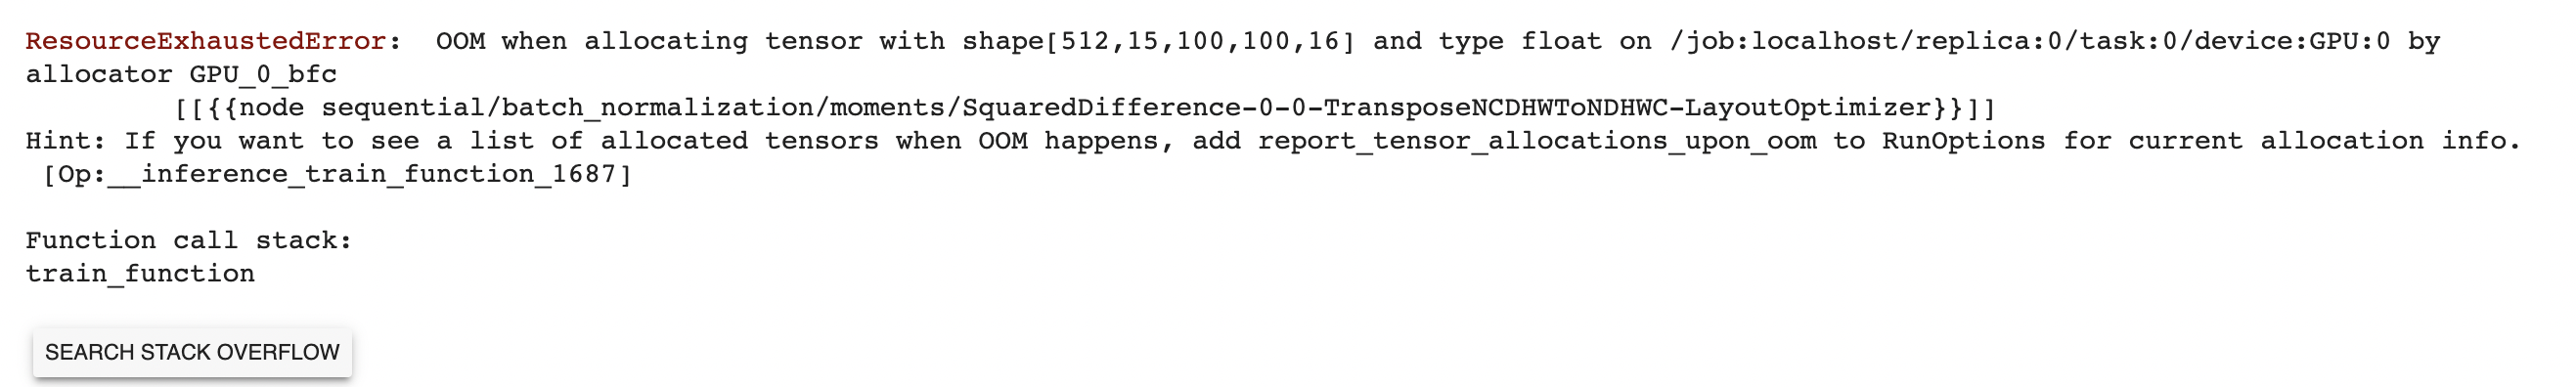

## Conclusion 
- Keeping large batch size was negatively affecting performance. 

- This observation is backed up by further resources as well. One such resource: 
  
  https://datascience.stackexchange.com/questions/12532/does-batch-size-in-keras-have-any-effects-in-results-quality


#### Image Processor ####
The objective of this function is:
Resize the images as per *transform_size* given by user, or take it as fixed size of (100,100).

**Reason**

In the training data we have 2 types of videos, where video frame size are as *(360,360)* and *(160,120)* Therefore to keep things consistent, we build an image processor which will perform cropping of the images.

**Note**

Cropping is done as a centered image, i.e., we take the center as the reference and crop the images from both sides. For (360,360) we can use skimage.transform.resize function. However, for *(160,120)* we will have to some manual processing to crop images by the center.

In [10]:
'''This method is used to process image based on its shape 
if image is of dimension (360,360,3) then we will use resize to (120,120,1)
else we will manual crop image of any other dimension '''
from skimage.transform import resize
def image_processor(original_image,transform_size = (100,100)):
    # If we have an image of (360,360,3) then we use resize function.
    new_image = original_image
    if original_image.shape == (360,360,3):
        new_image = resize(original_image,transform_size)
    else:
        # Manually crop the image using the below logic.
        start_row = (original_image.shape[0] - transform_size[0])//2
        end_row = start_row + transform_size[0]
            
        start_col = (original_image.shape[1] - transform_size[1])//2
        end_col = start_col + transform_size[1]
        new_image = original_image[start_row:end_row,start_col:end_col,:]
    return new_image

#### Sequence Generator ####
This function provides a list of frame sequences we would like to use for training.

Arguments

a) choice_of_list


choice_of_list | 0 | 1 | 2
-----------|---|---|---
Return list type | range(0,30,1) | range(0,30,2) | [0,1,2,3,4,5,6,9,12,15,18,21,24,25,26,27,28,29]

In [11]:
def get_frame_selection_list(choice_of_list=0):
    if choice_of_list == 0:
        return [frame for frame in range(0,30,1)] # Returns 100% of frames, number of frames=30
    elif choice_of_list == 1:
        return [frame for frame in range(0,30,2)] # returns 50% of frames, number of frames=15
    elif choice_of_list == 2:
        # For this we are taking first 5 frame + skip frame sequence + last 5 frame of the sequence
        frame_sequences = []
        start_frame_sequence = [0,1,2,3,4,5]
        end_frame_sequence = [25,26,27,28,29]
        skip_sequence = 3
        mid_frame_sequence = [k for k in range(6,25,skip_sequence)]
        
        frame_sequences.extend(start_frame_sequence)
        frame_sequences.extend(mid_frame_sequence)
        frame_sequences.extend(end_frame_sequence)
         
        return frame_sequences
    

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

This is heart of complete training process. It pumps batched data to network during learning and prediction both. The function description is given below:

Arguments

1. Source Path - Directory/Folder path to be considered for reading video/images frames.
2. folder_list - Lines from the train_doc we read above.
3. batch_size - The batch_size we want to select.
4. frame_selection - frame_list obtained from frame_generator (Default - range(30))
5. process_input_func - To be provided in case CNN2D+RNN type modelling being done.
6. base_model - To be provided in case CNN2D+RNN type modelling being done.

***Case 1 - when CNN2D+RNN modelling being done (RNN can be any of SimpleRNN/LSTM/GRU)***

In this case, for each batch (according to batch size), we build

1. **batch_data** = *(batch_size, number_of_frames,image_size_x,image_size_y,n_channels)*
2. reshape batch data as **batch_data.reshape(batch_size * number_of_frames , image_size_x , image_size_y , n_channels)**.
3. Above reshaped numpy array is sent to *process_input_func* of the pre-learned CNN2D function. This will produce modified image vector as per pre-learned CNN2D function (like VGG19/VGG16/etc.)
4. After *process_input_func* we reshape again to *(batch_size, number_of_frames, outputs from CNN2D vector)*

***Case 2 - when CNN3D modelling being done***

In this case, for each batch (according to batch size), we build 

1. **batch_data** = *(batch_size, number_of_frames,image_size_x,image_size_y,n_channels)*
2. We normalize each channel (RGB) by dividing the pixel value with 255.



***Final Output***

The final output of the function has a tuple which has the batch_data (processed) and one-hot-encoded Y variable.
One-hot-encoded numpy array will be of size (batch_size, 5) since we have 5 types of gestures.



In [12]:
def generator(source_path, folder_list, batch_size,frame_selection = range(30),process_input_func=None,base_model = None):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #index_selection = [i for i in range(0,30,2)] #create a list of image numbers you want to use for a particular video
    img_idx = frame_selection #create a list of image numbers you want to use for a particular video
    
    x = len(img_idx) #x: number of images used for each video
    y = 100 # image height
    z = 100 # width height
    channels = 3 # Number of channels
    transform_size = (100,100)
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//(batch_size)  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output (output: 0,1,2,3,4. Hence 5 possible outputs)
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image_path= source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    #Crop the images and resize them. Note that the images are of 2 different shapes 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image= image_processor(image,transform_size)   ##Crops Rectangular frames of 120x160 to 120x120
                    if base_model:
                        # This is when we are using a pre-learned CNN2D network
                        image = process_input_func(image)
                        
                    else:
                        # This is when we are building a Conv3D network
                        image = cv2.resize(image, (y,z), interpolation = cv2.INTER_AREA)  #Resizing 360x360 and 120x120 (cropped) images to 100x100

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if base_model:
                s1 = batch_data.shape
                n1 = base_model.predict(batch_data.reshape(s1[0]*s1[1],s1[2],s1[3],s1[4]))
                s2 = n1.shape
                batch_data = n1.reshape(s1[0],s1[1],s2[1]*s2[2]*s2[3])
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_size= len(t) - (num_batches*batch_size)
            batch= num_batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output (output: 0,1,2,3,4. Hence 5 possible outputs)
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image_path= source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    #crop the images and resize them. Note that the images are of 2 different shapes 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image= image_processor(image,transform_size)   ##Crops Rectangular frames of 120x160 to 120x120
                    if base_model:
                        # This is when we are using a pre-learned CNN2D network
                        image = process_input_func(image)
                        
                    else:
                        # This is when we are building a Conv3D network
                        image = cv2.resize(image, (y,z), interpolation = cv2.INTER_AREA)  #Resizing 360x360 and 120x120 (cropped) images to 100x100

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if base_model:
                s1 = batch_data.shape
                n1 = base_model.predict(batch_data.reshape(s1[0]*s1[1],s1[2],s1[3],s1[4]))
                s2 = n1.shape
                batch_data = n1.reshape(s1[0],s1[1],s2[1]*s2[2]*s2[3])
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = os.path.join(path_data,'','train')#'/notebooks/storage/Final_data/Collated_training/train'
val_path = os.path.join(path_data,'','val')#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


# Note
 
Num of epochs have been tested with 30 as well but things don't change after the 25th epoch. 

# Conv3D Models

In [14]:
train_data = train_doc
val_data = val_doc
batch_size = 32
num_epochs = 25
num_train_sequences = len(train_data)
num_val_sequences = len(val_data)
model_name = "model_Conv3D"

os.environ.putenv("HDF5_USE_FILE_LOCKING","FALSE")

#### Building Neural Network Model Architecture ####

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

#### Building up generator objects ####

train_generator for training data

val_generator for validation data

#### Setting up extra parameter for Neural Network ####

* ModelCheckPoint

We build modelcheckpoint to save models after every epoch, so that we can refer to models to best model later on for final testing.
* ReduceLROnPlateau

If the **val_loss** value stops improving after **patience** number of epochs, we reduce the learning rate so as to take smaller steps down the gradient route for reaching global minimum and avoid getting stuch at local minimum.

# Defining some methods here.

In [15]:
'''This method is used to save model .h5 file in the 
specified path as save_model/{model_type}/{model_num}
if this path does not exist then it will create one to save the model'''
def get_model_save_path(model_type='conv2d_RNN',model_num='Model1'):
    
    file_folder = 'save_model/'+model_type+'/'+model_num+'/'
    
    if not os.path.exists('save_model/'+model_type+'/'):
        os.mkdir('save_model/'+model_type+'/')
        
    if not os.path.exists(file_folder):
        os.mkdir(file_folder)
        
    save_file_name='model_init-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'    
    file_path = file_folder+save_file_name

    return file_path

In [16]:
'''This method will create the model check point and 
will write the log to the metric.csv file for each model'''
def get_model_callback_list(model_name,model_num):
    
    file_path = get_model_save_path(model_name,model_num)
    checkpoint = ModelCheckpoint(file_path, 
                                 monitor='val_loss', 
                                 verbose=1,
                                 save_best_only=False,
                                 save_weights_only=False,
                                 mode='auto',
                                 save_freq='epoch')
    # write the REducelronplateau code here
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                           patience=5, min_lr=0.001,verbose=1)
    #earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
    #Logging all evaluation metrics
    csv_logger= CSVLogger(os.path.join(os.path.dirname(file_path),'','metric_log.csv')
                                      , append=True,
                                      separator=',')
    
 
    return [csv_logger,checkpoint,LR],file_path

In [17]:
'''This latest .h5 file with its paths information so that when we start training a 
model and in case GPU crashes we will be abale to start traing from that specific epoch
without any need to train again from first epoch.
This will save GPU and is less time taking'''
def get_latest_check_point(file_path):
    folder_path=os.path.dirname(file_path)
    metric_path=os.path.join(folder_path,'','metric_log.csv')
    if os.path.exists(metric_path):
        df_metric=pd.read_csv(metric_path)
        latest=list(df_metric.epoch)[-1]+1
        search_string = "model_init-0{3,}"+str(latest)+"{1}[a-z0-9\-\.]*"
        latest_file=[f for f in os.listdir(folder_path) if re.search(search_string, f)][0]
        
    else:
        latest_file='No weight and model is saved yet.'
        latest=None
    print("Latest model name : %s" %(latest_file))
    print("Latest Epoch is %s" %(latest))
  
    return os.path.join(folder_path,'',latest_file),latest

In [18]:
'''This method will give the file path of the best model with maximum val_categorical_accuracy'''
def get_best_check_point(file_path):
    folder_path=os.path.dirname(file_path)
    metric_path=os.path.join(folder_path,'','metric_log.csv')
    if os.path.exists(metric_path):
        df_metric=pd.read_csv(metric_path)
        best_epoch=np.argmax(df_metric.val_categorical_accuracy)+1 #best epoch is where val_categorical_accuracy is maximum
        search_string = "model_init-0{3,}"+str(best_epoch)+"{1}[a-z0-9\-\.]*"
        best_file=[f for f in os.listdir(folder_path) if re.search(search_string, f)][0]
        print("Best model name : %s" %(best_file))
        print("Best Epoch is %s" %(best_epoch))
        
        val_categorical_accuracy=df_metric.val_categorical_accuracy.max()
        categorical_accuracy=df_metric['categorical_accuracy'][best_epoch-1]  
        print("Best model validation accuracy is :" ,val_categorical_accuracy)
        print("Best model train accuracy is :" ,categorical_accuracy)
    
    else:
        best_file = None
        best_epoch = None
        print("Model log and history not found in folder: ",file_path)
 
    return os.path.join(folder_path,'',best_file),best_epoch,[categorical_accuracy,val_categorical_accuracy]

In [19]:
'''As we are writing the log in csv file this method will pick the metric from the csv log file 
and will plot the loss and accuracy'''
def draw_evaluation_metric(file_path):
    metric_path=os.path.join(os.path.dirname(file_path),'','metric_log.csv')
    df_metric=pd.read_csv(metric_path)
    latest=np.argmax(df_metric.epoch)
    
    df_loss=df_metric[['loss','val_loss']]
    df_acc=df_metric[['categorical_accuracy','val_categorical_accuracy']]
    
    f,ax=plt.subplots(1,2,figsize=(15,5))
    
    ax[0].plot(range(1,latest+2),list(df_loss.loss),label='loss')
    ax[0].plot(range(1,latest+2),list(df_loss.val_loss),label='val_loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(range(1,latest+2),list(df_acc.categorical_accuracy),
           label='categorical_accuracy')
    ax[1].plot(range(1,latest+2),list(df_acc.val_categorical_accuracy)
           ,label='val_categorical_accuracy')
    ax[1].legend()
    ax[1].grid()

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [21]:
input_shape= (len(get_frame_selection_list(choice_of_list=1)),100,100,3)
input_shape

(15, 100, 100, 3)

In [22]:
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size,frame_selection = get_frame_selection_list(choice_of_list=1))
val_generator = generator(val_path, val_doc, batch_size,frame_selection = get_frame_selection_list(choice_of_list=1))

In [23]:
# These lists will be used to carry the model performance indicators. 
name = []
total_params = []
trainable_params = []
non_trainable_params = []
categorical_accuracy = []
val_categorical_accuracy = []
paths = []

## Model 1 using 16,16,32 kernels in 3 consecutive conv3D layers

In [24]:
## Model1

# 16,16,32 kernels in 3 consecutive conv3D layers
model1 = Sequential()
# 1st Layer Group
model1.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))


# 2nd Layer Group
model1.add(Conv3D(16, kernel_size=(3,3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

# 3rd Layer Group
model1.add(Conv3D(32, kernel_size=(3,3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

# Fully Connected layer group
model1.add(Flatten())
model1.add(Dense(512 , activation='relu'))
model1.add(Dropout(0.1))

# Softmax Layer
model1.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [25]:
optimiser = optimizers.SGD(lr=0.01) #write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation (Activation)      (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 50, 50, 16)     6928      
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 50, 50, 16)     64        
_________________________________________________________________
activation_1 (Activation)    (None, 7, 50, 50, 16)     0

#################################################################

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [26]:
callbacks_list,file_path = get_model_callback_list('CNN_3D','model1')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/CNN_3D/model1


In [27]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : No weight and model is saved yet.
Latest Epoch is None


In [28]:
print(latest_weight)
print(latest_epoch)

save_model/CNN_3D/model1\No weight and model is saved yet.
None


In [29]:
if latest_epoch==None:
    last_epoch=0
else:
    last_epoch=latest_epoch  #Start training where we left using initial_epoch
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)

    model1=tf.keras.models.load_model(latest_weight)

model1_fit = model1.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=num_epochs,
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1)

Source path =  C:\Data\Project_data\train ; batch size = 32
Epoch 1/25
21/21 [==============================] - 72s 3s/step - loss: 2.3983 - categorical_accuracy: 0.3725 - val_loss: 1.5751 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to save_model/CNN_3D/model1\model_init-00001-2.39829-0.37255-1.57510-0.22000.h5
Epoch 2/25
21/21 [==============================] - 39s 2s/step - loss: 1.0498 - categorical_accuracy: 0.5611 - val_loss: 1.5822 - val_categorical_accuracy: 0.3125

Epoch 00002: saving model to save_model/CNN_3D/model1\model_init-00002-1.04979-0.56108-1.58215-0.31250.h5
Epoch 3/25
21/21 [==============================] - 35s 2s/step - loss: 0.8120 - categorical_accuracy: 0.6651 - val_loss: 2.0408 - val_categorical_accuracy: 0.1875

Epoch 00003: saving model to save_model/CNN_3D/model1\model_init-00003-0.81201-0.66511-2.04083-0.18750.h5
Epoch 4/25
21/21 [==============================] - 35s 2s/step - loss: 0.6949 - categorical_accuracy: 0.7368 - val_loss: 2.230

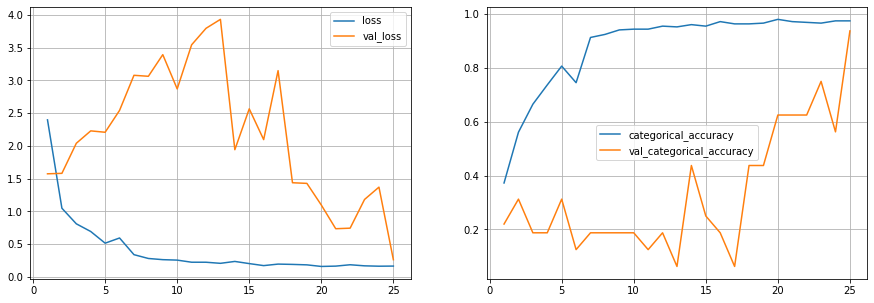

In [30]:
draw_evaluation_metric(file_path)

In [31]:
path,best_epoch,metric_parms = get_best_check_point(file_path)


Best model name : model_init-00025-0.16720-0.97479-0.26504-0.93750.h5
Best Epoch is 25
Best model validation accuracy is : 0.9375
Best model train accuracy is : 0.9747899174690248


In [32]:
param_count_model1 = param_count(model1)
name.append('model_1')
total_params.append(param_count_model1[0] )
trainable_params.append(param_count_model1[1] )
non_trainable_params.append(param_count_model1[2] )

categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 2,384,725
Trainable params: 2,384,597
Non-trainable params: 128


# Observation

Model is very good now, let's try increasing the number of filters/kernals and see the results.

## Model 2 increasing the number of filters/kernals. 

In [33]:
# Model 2
# 16,32,32 kernels in 3 consecutive conv3D layers
model2 = Sequential()
# 1st Layer Group
model2.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))


# 2nd Layer Group increasing the number of kernals/filters
model2.add(Conv3D(32, kernel_size=(3,3,3),padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

# 3rd Layer Group
model2.add(Conv3D(32, kernel_size=(3,3,3),padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

# Fully Connected layer group
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.1))
# Softmax Layer
model2.add(Dense(5, activation='softmax'))

In [35]:
optimiser =  optimizers.Adam() #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_3 (Activation)    (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 50, 50, 32)     128       
_________________________________________________________________
activation_4 (Activation)    (None, 7, 50, 50, 32)    

In [36]:
callbacks_list,file_path = get_model_callback_list('CNN_3D','model2')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/CNN_3D/model2


In [37]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : No weight and model is saved yet.
Latest Epoch is None


In [38]:
if latest_epoch==None:
    last_epoch=0
else:
    last_epoch=latest_epoch  #Start training where we left using initial_epoch
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)

    model2=tf.keras.models.load_model(latest_weight)

model2_fit = model2.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=num_epochs,
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1)

Epoch 1/25
21/21 [==============================] - 32s 2s/step - loss: 4.7455 - categorical_accuracy: 0.2997 - val_loss: 1.6132 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to save_model/CNN_3D/model2\model_init-00001-4.74547-0.29972-1.61316-0.25000.h5
Epoch 2/25
21/21 [==============================] - 34s 2s/step - loss: 1.3867 - categorical_accuracy: 0.4034 - val_loss: 1.5217 - val_categorical_accuracy: 0.3750

Epoch 00002: saving model to save_model/CNN_3D/model2\model_init-00002-1.38667-0.40336-1.52171-0.37500.h5
Epoch 3/25
21/21 [==============================] - 32s 2s/step - loss: 1.0182 - categorical_accuracy: 0.6134 - val_loss: 1.8516 - val_categorical_accuracy: 0.1875

Epoch 00003: saving model to save_model/CNN_3D/model2\model_init-00003-1.01820-0.61345-1.85160-0.18750.h5
Epoch 4/25
21/21 [==============================] - 29s 1s/step - loss: 0.7633 - categorical_accuracy: 0.6835 - val_loss: 1.4907 - val_categorical_accuracy: 0.5000

Epoch 00004: saving mo

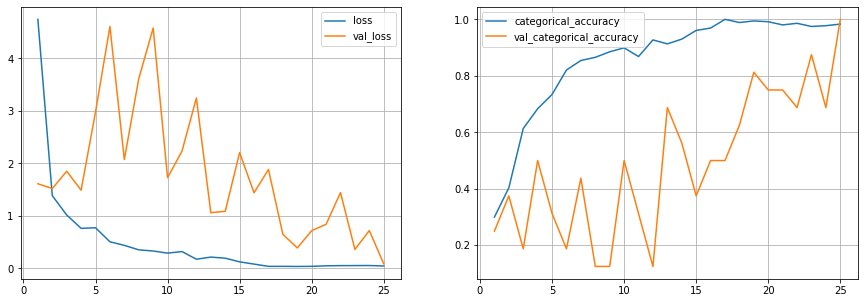

In [39]:
draw_evaluation_metric(file_path)

In [40]:
path,best_epoch,metric_parms = get_best_check_point(file_path)

Best model name : model_init-00025-0.04614-0.98319-0.08734-1.00000.h5
Best Epoch is 25
Best model validation accuracy is : 1.0
Best model train accuracy is : 0.9831932783126832


# Observation

- This model is even better than the first one with very good validation accuracy.
- We will try increasing the number of filters and see what happens to the model accuracy.

In [41]:
param_count_model2 = param_count(model2)

name.append('model_2')
total_params.append(param_count_model2[0] )
trainable_params.append(param_count_model2[1] )
non_trainable_params.append(param_count_model2[2] )

categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 2,405,541
Trainable params: 2,405,381
Non-trainable params: 160


# Model 3 increasing the number of filters in third layer to 64.

In [42]:
# Model 3
# 16,32,64 kernels in 3 consecutive conv3D layers
model3 = Sequential()
# 1st Layer Group
model3.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))


# 2nd Layer Group
model3.add(Conv3D(32, kernel_size=(3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

# 3rd Layer Group
model3.add(Conv3D(64, kernel_size=(3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

# Fully Connected layer group
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.1))
# Softmax Layer
model3.add(Dense(5, activation='softmax'))

In [44]:
optimiser = optimizers.Adam() #write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_6 (Activation)    (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 50, 50, 32)     128       
_________________________________________________________________
activation_7 (Activation)    (None, 7, 50, 50, 32)    

In [45]:
callbacks_list,file_path = get_model_callback_list('CNN_3D','model3')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/CNN_3D/model3


In [46]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : No weight and model is saved yet.
Latest Epoch is None


In [47]:
if latest_epoch==None:
    last_epoch=0
else:
    last_epoch=latest_epoch  #Start training where we left using initial_epoch
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)

    model3=tf.keras.models.load_model(latest_weight)

model3_fit = model3.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=num_epochs,
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1)

Epoch 1/25
21/21 [==============================] - 34s 2s/step - loss: 9.6917 - categorical_accuracy: 0.3165 - val_loss: 1.8290 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to save_model/CNN_3D/model3\model_init-00001-9.69167-0.31653-1.82897-0.25000.h5
Epoch 2/25
21/21 [==============================] - 30s 2s/step - loss: 1.6876 - categorical_accuracy: 0.2941 - val_loss: 1.5220 - val_categorical_accuracy: 0.3125

Epoch 00002: saving model to save_model/CNN_3D/model3\model_init-00002-1.68761-0.29412-1.52202-0.31250.h5
Epoch 3/25
21/21 [==============================] - 35s 2s/step - loss: 1.1361 - categorical_accuracy: 0.5574 - val_loss: 1.4754 - val_categorical_accuracy: 0.1875

Epoch 00003: saving model to save_model/CNN_3D/model3\model_init-00003-1.13611-0.55742-1.47540-0.18750.h5
Epoch 4/25
21/21 [==============================] - 34s 2s/step - loss: 1.0250 - categorical_accuracy: 0.5798 - val_loss: 1.8415 - val_categorical_accuracy: 0.3125

Epoch 00004: saving mo

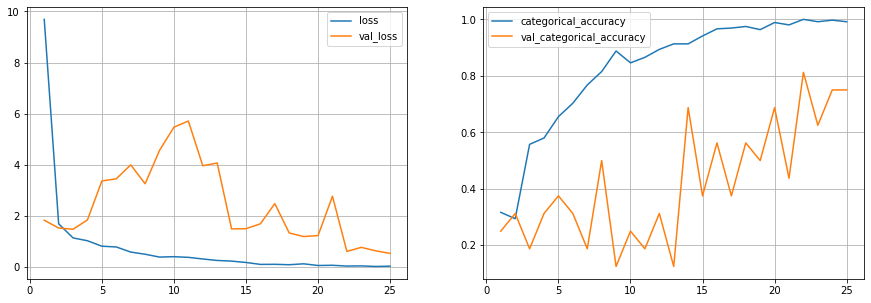

In [48]:
draw_evaluation_metric(file_path)

In [49]:
path,best_epoch,metric_parms = get_best_check_point(file_path)


Best model name : model_init-00022-0.03386-1.00000-0.60782-0.81250.h5
Best Epoch is 22
Best model validation accuracy is : 0.8125
Best model train accuracy is : 1.0


In [50]:
param_count_model3 = param_count(model3)

name.append('model_3')
total_params.append(param_count_model3[0] )
trainable_params.append(param_count_model3[1] )
non_trainable_params.append(param_count_model3[2] )

categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 4,792,645
Trainable params: 4,792,421
Non-trainable params: 224


# Observation

- This model is an overfitted model as seen the training accuracy is very high and validation accuracy is low.
- Lets try decreasing the number of filters in the next model. 

# Model 4 using 16,64,64 kernels/filters in all the 3 layers.

In [51]:
# Model 4
# 16,64,64 kernels in 3 consecutive conv3D layers
model4 = Sequential()
# 1st Layer Group
model4.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))


# 2nd Layer Group
model4.add(Conv3D(64, kernel_size=(3,3,3),padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

# 3rd Layer Group
model4.add(Conv3D(64, kernel_size=(3,3,3),padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

# Fully Connected layer group
model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.1))
# Softmax Layer
model4.add(Dense(5, activation='softmax'))

In [52]:
optimiser = optimizers.Adam() #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_9 (Batch (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_9 (Activation)    (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 7, 50, 50, 64)     27712     
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 50, 50, 64)     256       
_________________________________________________________________
activation_10 (Activation)   (None, 7, 50, 50, 64)    

In [53]:
callbacks_list,file_path = get_model_callback_list('CNN_3D','model4')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/CNN_3D/model4


In [54]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : No weight and model is saved yet.
Latest Epoch is None


In [55]:
if latest_epoch==None:
    last_epoch=0
else:
    last_epoch=latest_epoch  #Start training where we left using initial_epoch
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)

    model4=tf.keras.models.load_model(latest_weight)

model4_fit = model4.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=num_epochs,
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1)

Epoch 1/25
21/21 [==============================] - 31s 1s/step - loss: 5.7374 - categorical_accuracy: 0.3053 - val_loss: 1.6442 - val_categorical_accuracy: 0.3750

Epoch 00001: saving model to save_model/CNN_3D/model4\model_init-00001-5.73738-0.30532-1.64423-0.37500.h5
Epoch 2/25
21/21 [==============================] - 30s 1s/step - loss: 1.3044 - categorical_accuracy: 0.4790 - val_loss: 1.4864 - val_categorical_accuracy: 0.3750

Epoch 00002: saving model to save_model/CNN_3D/model4\model_init-00002-1.30441-0.47899-1.48641-0.37500.h5
Epoch 3/25
21/21 [==============================] - 33s 2s/step - loss: 1.0020 - categorical_accuracy: 0.6106 - val_loss: 2.8914 - val_categorical_accuracy: 0.1875

Epoch 00003: saving model to save_model/CNN_3D/model4\model_init-00003-1.00197-0.61064-2.89136-0.18750.h5
Epoch 4/25
21/21 [==============================] - 35s 2s/step - loss: 0.7846 - categorical_accuracy: 0.6667 - val_loss: 3.9141 - val_categorical_accuracy: 0.1250

Epoch 00004: saving mo

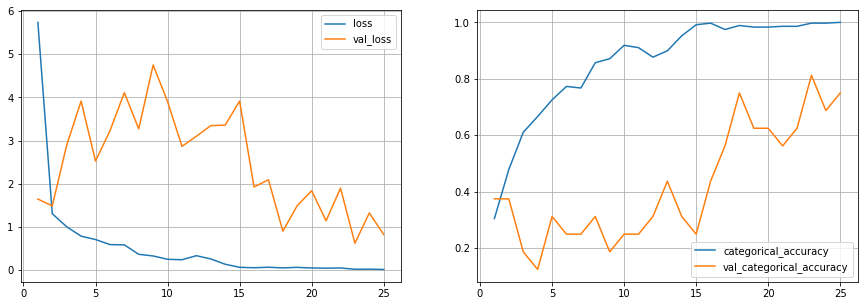

In [56]:
draw_evaluation_metric(file_path)

In [57]:
path,best_epoch,metric_parms = get_best_check_point(file_path)

Best model name : model_init-00023-0.01827-0.99720-0.62010-0.81250.h5
Best Epoch is 23
Best model validation accuracy is : 0.8125
Best model train accuracy is : 0.9971988797187804


In [58]:
param_count_model4 = param_count(model4)

name.append('model_4')
total_params.append(param_count_model4[0] )
trainable_params.append(param_count_model4[1] )
non_trainable_params.append(param_count_model4[2] )

categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 4,861,925
Trainable params: 4,861,637
Non-trainable params: 288


# Observation

- Unable to overcome overfitting issue even after reducing the number of filters. 
- This model is clearly an overfit as there is large difference between train and validation accuracy. 
- Adding additional dense layer now to resolve overfitting issue.

# Model 5 adding additional dense layer with 128 neurons.

In [59]:
# Model 5
# 16,32,32 kernels in 3 consecutive conv3D layers
model5 = Sequential()
# 1st Layer Group
model5.add(Conv3D(16, kernel_size=(2,2,2), input_shape=input_shape,padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))


# 2nd Layer Group
model5.add(Conv3D(32, kernel_size=(2,2,2),padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))

# 3rd Layer Group
model5.add(Conv3D(32, kernel_size=(2,2,2),padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))

# Fully Connected layer group
model5.add(Flatten())
model5.add(Dense(512,activation='relu'))
model5.add(Dropout(0.1))

# Fully Connected layer group
model5.add(Dense(128,activation='relu'))
model5.add(Dropout(0.15))

# Softmax Layer
model5.add(Dense(5, activation='softmax'))

In [60]:
optimiser = optimizers.Adam() #write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 15, 100, 100, 16)  400       
_________________________________________________________________
batch_normalization_12 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_12 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 7, 50, 50, 32)     4128      
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 50, 50, 32)     128       
_________________________________________________________________
activation_13 (Activation)   (None, 7, 50, 50, 32)    

In [61]:
callbacks_list,file_path = get_model_callback_list('CNN_3D','model5')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/CNN_3D/model5


In [62]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : No weight and model is saved yet.
Latest Epoch is None


In [63]:
if latest_epoch==None:
    last_epoch=0
else:
    last_epoch=latest_epoch  #Start training where we left using initial_epoch
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)

    model5=tf.keras.models.load_model(latest_weight)

model5_fit = model5.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=num_epochs,
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1)

Epoch 1/25
21/21 [==============================] - 29s 1s/step - loss: 2.9852 - categorical_accuracy: 0.3305 - val_loss: 1.5949 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to save_model/CNN_3D/model5\model_init-00001-2.98521-0.33053-1.59490-0.25000.h5
Epoch 2/25
21/21 [==============================] - 28s 1s/step - loss: 1.1940 - categorical_accuracy: 0.5098 - val_loss: 1.8267 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to save_model/CNN_3D/model5\model_init-00002-1.19402-0.50980-1.82674-0.25000.h5
Epoch 3/25
21/21 [==============================] - 27s 1s/step - loss: 0.8629 - categorical_accuracy: 0.6331 - val_loss: 2.1152 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to save_model/CNN_3D/model5\model_init-00003-0.86293-0.63305-2.11521-0.25000.h5
Epoch 4/25
21/21 [==============================] - 28s 1s/step - loss: 0.8291 - categorical_accuracy: 0.6639 - val_loss: 2.5412 - val_categorical_accuracy: 0.3125

Epoch 00004: saving mo

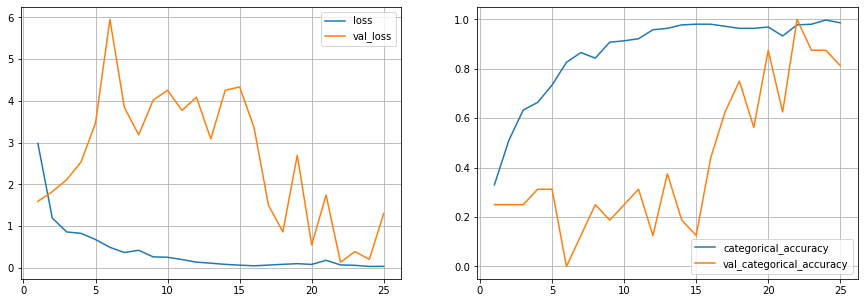

In [64]:
draw_evaluation_metric(file_path)

In [65]:
path,best_epoch,metric_parms = get_best_check_point(file_path)

Best model name : model_init-00022-0.07308-0.97759-0.13657-1.00000.h5
Best Epoch is 22
Best model validation accuracy is : 1.0
Best model train accuracy is : 0.977591037750244


In [66]:
param_count_model5 = param_count(model5)

name.append('model_5')
total_params.append(param_count_model5[0] )
trainable_params.append(param_count_model5[1] )
non_trainable_params.append(param_count_model5[2] )

categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 2,439,189
Trainable params: 2,439,029
Non-trainable params: 160


# Observation

- The problem of overfitting seems to have improved. 
- Let's try to increase the kernel size in further model.

# Model 6 by increasing the kernel/filter size to 5 x 5. 

In [67]:
# Model 6
# 16,32,32 kernels in 3 consecutive conv3D layers
model6 = Sequential()
# 1st Layer Group
model6.add(Conv3D(16, kernel_size=(5,5,5), input_shape=input_shape,padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(2,2,2)))


# 2nd Layer Group
model6.add(Conv3D(32, kernel_size=(5,5,5),padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(2,2,2)))

# 3rd Layer Group
model6.add(Conv3D(32, kernel_size=(5,5,5),padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(2,2,2)))

#Fully Connected layer group
model6.add(Flatten())
model6.add(Dense(512,activation='relu'))
model6.add(Dropout(0.1))

model6.add(Dense(128,activation='relu'))
model6.add(Dropout(0.15))

# Softmax Layer
model6.add(Dense(5, activation='softmax'))

In [68]:
optimiser = optimizers.Adam() #write your optimizer
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 15, 100, 100, 16)  6016      
_________________________________________________________________
batch_normalization_15 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_15 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 7, 50, 50, 32)     64032     
_________________________________________________________________
batch_normalization_16 (Batc (None, 7, 50, 50, 32)     128       
_________________________________________________________________
activation_16 (Activation)   (None, 7, 50, 50, 32)    

In [69]:
callbacks_list,file_path = get_model_callback_list('CNN_3D','model6')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/CNN_3D/model6


In [70]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : No weight and model is saved yet.
Latest Epoch is None


In [71]:
if latest_epoch==None:
    last_epoch=0
else:
    last_epoch=latest_epoch  #Start training where we left using initial_epoch
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)

    model6=tf.keras.models.load_model(latest_weight)

model6_fit = model6.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=num_epochs,
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1)

Epoch 1/25
21/21 [==============================] - 31s 1s/step - loss: 2.7565 - categorical_accuracy: 0.2297 - val_loss: 13.5980 - val_categorical_accuracy: 0.1875

Epoch 00001: saving model to save_model/CNN_3D/model6\model_init-00001-2.75648-0.22969-13.59804-0.18750.h5
Epoch 2/25
21/21 [==============================] - 31s 2s/step - loss: 1.4679 - categorical_accuracy: 0.3081 - val_loss: 5.3202 - val_categorical_accuracy: 0.1875

Epoch 00002: saving model to save_model/CNN_3D/model6\model_init-00002-1.46794-0.30812-5.32021-0.18750.h5
Epoch 3/25
21/21 [==============================] - 30s 1s/step - loss: 1.3144 - categorical_accuracy: 0.4146 - val_loss: 3.5411 - val_categorical_accuracy: 0.1875

Epoch 00003: saving model to save_model/CNN_3D/model6\model_init-00003-1.31445-0.41457-3.54107-0.18750.h5
Epoch 4/25
21/21 [==============================] - 33s 2s/step - loss: 1.1896 - categorical_accuracy: 0.4846 - val_loss: 2.3449 - val_categorical_accuracy: 0.3125

Epoch 00004: saving 

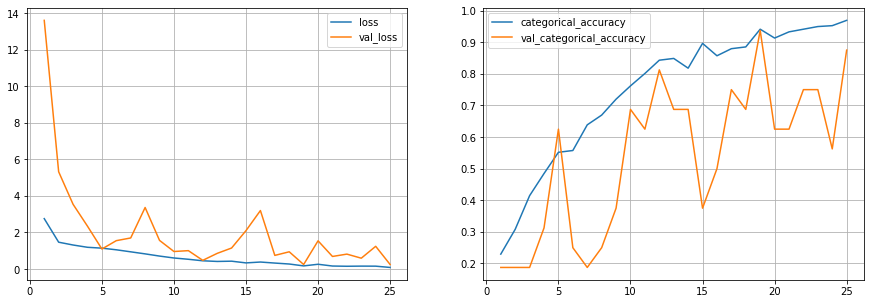

In [72]:
draw_evaluation_metric(file_path)

In [73]:
path,best_epoch,metric_parms = get_best_check_point(file_path)

Best model name : model_init-00019-0.17226-0.94118-0.24788-0.93750.h5
Best Epoch is 19
Best model validation accuracy is : 0.9375
Best model train accuracy is : 0.9411764740943908


In [74]:
param_count_model6 = param_count(model6)

name.append('model_6')
total_params.append(param_count_model6[0] )
trainable_params.append(param_count_model6[1] )
non_trainable_params.append(param_count_model6[2] )

categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 2,624,517
Trainable params: 2,624,357
Non-trainable params: 160


# Observation
- Increasing the kernal size has significantly improved the overall model accuracy and loss.
- We will now try to build model with stride 1 and same padding type and see the results.

# Model 7 with stride of 1 and 'same' padding

In [75]:
# Model 7
# 32,64,64 kernels in 3 consecutive conv3D layers
model7 = Sequential()
# 1st Layer Group
model7.add(Conv3D(32, kernel_size=(3,3,3), strides=(1,1,1) , input_shape=input_shape,padding='same'))
model7.add(BatchNormalization())
model7.add(Activation('relu'))
model7.add(MaxPooling3D(pool_size=(2,2,2)))


# 2nd Layer Group
model7.add(Conv3D(64, kernel_size=(3,3,3),strides=(1,1,1) ,padding='same'))
model7.add(BatchNormalization())
model7.add(Activation('relu'))
model7.add(MaxPooling3D(pool_size=(2,2,2)))

# 3rd Layer Group
model7.add(Conv3D(64, kernel_size=(3,3,3),padding='same'))
model7.add(BatchNormalization())
model7.add(Activation('relu'))
model7.add(MaxPooling3D(pool_size=(2,2,2)))


#FC layer group
model7.add(Flatten())
model7.add(Dense(512,activation='relu'))
model7.add(Dropout(0.1))

model7.add(Dense(128,activation='relu'))
model7.add(Dropout(0.15))

# Softmax Layer
model7.add(Dense(5, activation='softmax'))

In [76]:
optimiser = optimizers.Adam() #write your optimizer
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 15, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_18 (Batc (None, 15, 100, 100, 32)  128       
_________________________________________________________________
activation_18 (Activation)   (None, 15, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 7, 50, 50, 32)     0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 7, 50, 50, 64)     55360     
_________________________________________________________________
batch_normalization_19 (Batc (None, 7, 50, 50, 64)     256       
_________________________________________________________________
activation_19 (Activation)   (None, 7, 50, 50, 64)    

In [77]:
callbacks_list,file_path = get_model_callback_list('CNN_3D','model7')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/CNN_3D/model7


In [78]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : No weight and model is saved yet.
Latest Epoch is None


In [79]:
if latest_epoch==None:
    last_epoch=0
else:
    last_epoch=latest_epoch  #Start training where we left using initial_epoch
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)

    model7=tf.keras.models.load_model(latest_weight)

model7_fit = model7.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=num_epochs,
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1)

Epoch 1/25
21/21 [==============================] - 34s 2s/step - loss: 3.8531 - categorical_accuracy: 0.2969 - val_loss: 2.8368 - val_categorical_accuracy: 0.3125

Epoch 00001: saving model to save_model/CNN_3D/model7\model_init-00001-3.85307-0.29692-2.83685-0.31250.h5
Epoch 2/25
21/21 [==============================] - 32s 2s/step - loss: 1.2899 - categorical_accuracy: 0.4286 - val_loss: 1.5729 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to save_model/CNN_3D/model7\model_init-00002-1.28994-0.42857-1.57293-0.25000.h5
Epoch 3/25
21/21 [==============================] - 29s 1s/step - loss: 0.9421 - categorical_accuracy: 0.6190 - val_loss: 2.7951 - val_categorical_accuracy: 0.1250

Epoch 00003: saving model to save_model/CNN_3D/model7\model_init-00003-0.94207-0.61905-2.79508-0.12500.h5
Epoch 4/25
21/21 [==============================] - 31s 2s/step - loss: 0.8150 - categorical_accuracy: 0.6863 - val_loss: 3.7664 - val_categorical_accuracy: 0.1250

Epoch 00004: saving mo

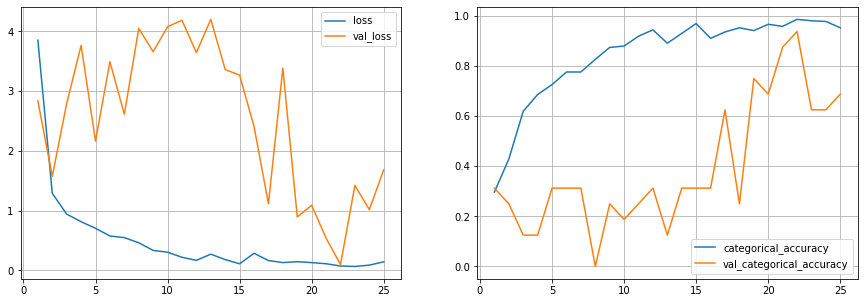

In [80]:
draw_evaluation_metric(file_path)

In [81]:
path,best_epoch,metric_parms = get_best_check_point(file_path)

Best model name : model_init-00022-0.07318-0.98599-0.09911-0.93750.h5
Best Epoch is 22
Best model validation accuracy is : 0.9375
Best model train accuracy is : 0.9859943985939026


In [82]:
param_count_model7 = param_count(model7)

name.append('model_7')
total_params.append(param_count_model7[0] )
trainable_params.append(param_count_model7[1] )
non_trainable_params.append(param_count_model7[2] )

categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 4,954,693
Trainable params: 4,954,373
Non-trainable params: 320


# Observations
- Adding stride increases the number of training params but doesnot increase the validation accuracy from the last model.
- We will now build a model with stride of 2 and valid padding type.

# Model 8 with stride of 2 and 'valid' (means no padding) padding.

In [83]:
# Model 8
# 32,64,64 kernels in 3 consecutive conv3D layers
model8 = Sequential()
# 1st Layer Group
model8.add(Conv3D(32, kernel_size=(3,3,3), strides=(2,2,2) , input_shape=input_shape,padding='valid'))
model8.add(BatchNormalization())
model8.add(Activation('relu'))
model8.add(MaxPooling3D(pool_size=(2,2,2)))


# 2nd Layer Group
model8.add(Conv3D(64, kernel_size=(3,3,3),strides=(1,1,1) ,padding='same'))
model8.add(BatchNormalization())
model8.add(Activation('relu'))

# 3rd Layer Group
model8.add(Conv3D(64, kernel_size=(2,2,2),padding='same'))
model8.add(BatchNormalization())
model8.add(Activation('relu'))
model8.add(MaxPooling3D(pool_size=(2,2,2)))


#FC layer group
model8.add(Flatten())
model8.add(Dense(512,activation='relu'))
model8.add(Dropout(0.1))

model8.add(Dense(128,activation='relu'))
model8.add(Dropout(0.15))

# Softmax Layer
model8.add(Dense(5, activation='softmax'))

In [84]:
optimiser = optimizers.Adam() #write your optimizer
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 7, 49, 49, 32)     2624      
_________________________________________________________________
batch_normalization_21 (Batc (None, 7, 49, 49, 32)     128       
_________________________________________________________________
activation_21 (Activation)   (None, 7, 49, 49, 32)     0         
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 3, 24, 24, 32)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 3, 24, 24, 64)     55360     
_________________________________________________________________
batch_normalization_22 (Batc (None, 3, 24, 24, 64)     256       
_________________________________________________________________
activation_22 (Activation)   (None, 3, 24, 24, 64)    

In [85]:
callbacks_list,file_path = get_model_callback_list('CNN_3D','model8')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/CNN_3D/model8


In [86]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : No weight and model is saved yet.
Latest Epoch is None


In [87]:
if latest_epoch==None:
    last_epoch=0
else:
    last_epoch=latest_epoch  #Start training where we left using initial_epoch
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)

    model8=tf.keras.models.load_model(latest_weight)

model8_fit = model8.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=num_epochs,
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1)

Epoch 1/25
21/21 [==============================] - 28s 1s/step - loss: 5.3268 - categorical_accuracy: 0.2549 - val_loss: 1.9671 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to save_model/CNN_3D/model8\model_init-00001-5.32680-0.25490-1.96709-0.50000.h5
Epoch 2/25
21/21 [==============================] - 29s 1s/step - loss: 1.4575 - categorical_accuracy: 0.3697 - val_loss: 1.6347 - val_categorical_accuracy: 0.1875

Epoch 00002: saving model to save_model/CNN_3D/model8\model_init-00002-1.45748-0.36975-1.63472-0.18750.h5
Epoch 3/25
21/21 [==============================] - 31s 2s/step - loss: 1.3415 - categorical_accuracy: 0.4146 - val_loss: 1.5323 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to save_model/CNN_3D/model8\model_init-00003-1.34147-0.41457-1.53226-0.25000.h5
Epoch 4/25
21/21 [==============================] - 34s 2s/step - loss: 1.1133 - categorical_accuracy: 0.5378 - val_loss: 2.0173 - val_categorical_accuracy: 0.0625

Epoch 00004: saving mo

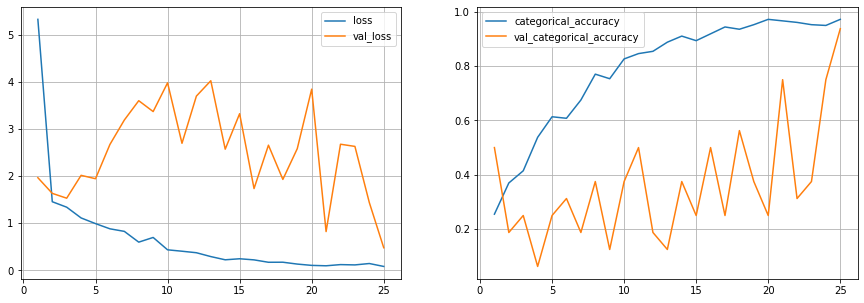

In [88]:
draw_evaluation_metric(file_path)

In [89]:
path,best_epoch,metric_parms = get_best_check_point(file_path)

Best model name : model_init-00025-0.08427-0.97199-0.48102-0.93750.h5
Best Epoch is 25
Best model validation accuracy is : 0.9375
Best model train accuracy is : 0.9719887971878052


In [90]:
param_count_model8 = param_count(model8)
name.append('model_8')
total_params.append(param_count_model8[0] )
trainable_params.append(param_count_model8[1] )
non_trainable_params.append(param_count_model8[2] )

categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 4,876,869
Trainable params: 4,876,549
Non-trainable params: 320


# Observations
- This model doesnot improve from the last model in terms of validation accuracy.

In [91]:
data = {'name': name,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'non_trainable_params': non_trainable_params,
        'categorical_accuracy':categorical_accuracy,
        'val_categorical_accuracy': val_categorical_accuracy,
        'paths':paths
       }

model_params = pd.DataFrame(data)

In [92]:
model_params

,name,total_params,trainable_params,non_trainable_params,categorical_accuracy,val_categorical_accuracy,paths
0,model_1,2384725,2384597,128,0.974790,0.9375,save_model/CNN_3D/model1\model_init-00025-0.16...
1,model_2,2405541,2405381,160,0.983193,1.0000,save_model/CNN_3D/model2\model_init-00025-0.04...
2,model_3,4792645,4792421,224,1.000000,0.8125,save_model/CNN_3D/model3\model_init-00022-0.03...
3,model_4,4861925,4861637,288,0.997199,0.8125,save_model/CNN_3D/model4\model_init-00023-0.01...
4,model_5,2439189,2439029,160,0.977591,1.0000,save_model/CNN_3D/model5\model_init-00022-0.07...
5,model_6,2624517,2624357,160,0.941176,0.9375,save_model/CNN_3D/model6\model_init-00019-0.17...
6,model_7,4954693,4954373,320,0.985994,0.9375,save_model/CNN_3D/model7\model_init-00022-0.07...
7,model_8,4876869,4876549,320,0.971989,0.9375,save_model/CNN_3D/model8\model_init-00025-0.08...


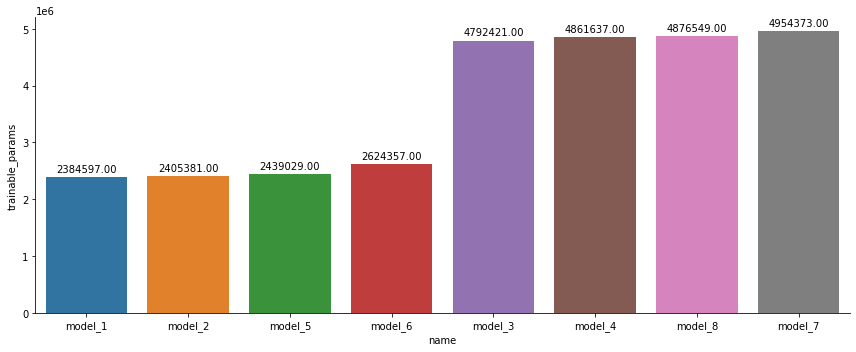

In [93]:
import seaborn as sns
fig = plt.figure(figsize=(12,5))
ax = sns.barplot(x="name", y="trainable_params", data=model_params, order=model_params.sort_values('trainable_params').name)
ax = annotate_graph(ax)
sns.despine()
plt.tight_layout()

# Observations
- Model_1,Model_2,Model_5,Model_6 have comparatively less number of training parameters.
- Model_3,Model_4,Model_8,Model_7 have comparatively more number of training parameters and hence takes for time to train.

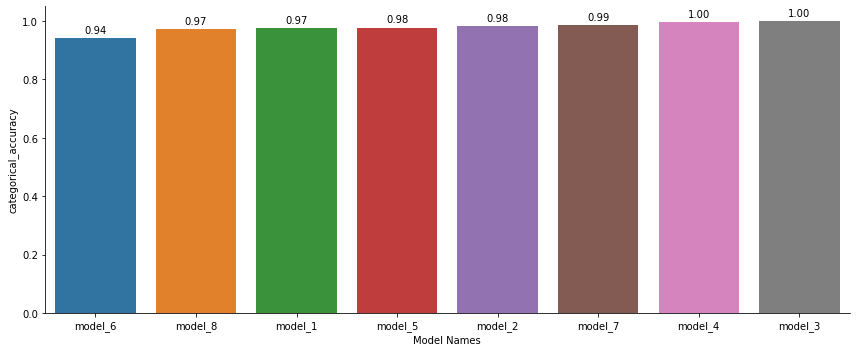

In [94]:
fig = plt.figure(figsize=(12,5))
ax = sns.barplot(x="name", y="categorical_accuracy", data=model_params, order=model_params.sort_values('categorical_accuracy').name)
ax = annotate_graph(ax)
sns.despine()
plt.tight_layout()
plt.xlabel('Model Names')
plt.show()

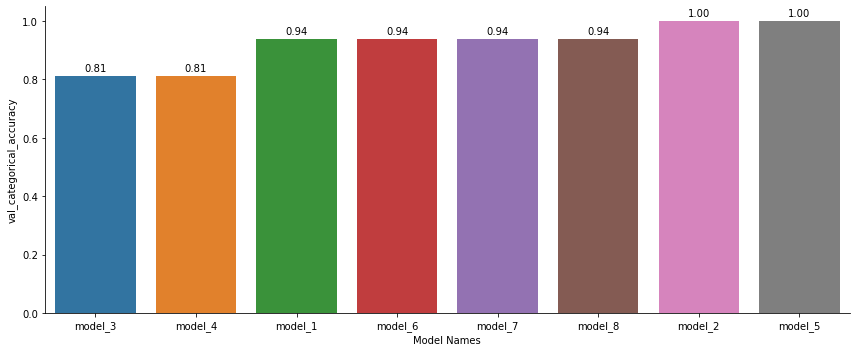

In [95]:
fig = plt.figure(figsize=(12,5))
ax = sns.barplot(x="name", y="val_categorical_accuracy", data=model_params, order=model_params.sort_values('val_categorical_accuracy').name)
ax = annotate_graph(ax)
sns.despine()
plt.tight_layout()
plt.xlabel('Model Names')
plt.show()

# Observations
- Model_2 and model_5 seems to be performing good with 100 % of validation accuracy given it has less number of trainable parameters.
- Model_4 and Model_3 is clearly `overfitting` with high training accuracy and low validation accuracy.
- So, Model_2,Model_5,Model_8 is not very good model as compared to others as the difference in training and validation accuracy is high.
- Model_1,Model_5,Model_6,Model_7 are all good enough with less difference in training and validation accuracy and is having high validation accuracy.
- Overall we can say Model_2 is one of the best having 100 % of validation accuracy given it has less number of trainable parameters.

### Selecting h5 file for loading best model

In [96]:
# Finding the index of the best model
idx_model = np.argmax(model_params.val_categorical_accuracy)
print('Best model is ',model_params['name'][idx_model])

Best model is  model_2


In [97]:
path = model_params['paths'][idx_model]
print('Path to the best weight is :: ',path)
selected_model = tf.keras.models.load_model(path)

Path to the best weight is ::  save_model/CNN_3D/model2\model_init-00025-0.04614-0.98319-0.08734-1.00000.h5


#### Performing prediction on validation data ####

In [98]:
testing_val_generator = generator(val_path, val_doc, batch_size,
                                  frame_selection = get_frame_selection_list(choice_of_list=1))
result = None
for x in range(validation_steps):
    x_val,y_val = next(testing_val_generator)
    p_val = selected_model.predict(x_val,batch_size=batch_size,verbose=1)
    if x == 0:
        result = np.vstack((y_val.argmax(axis=1),p_val.argmax(axis=1)))
    else:
        result = np.hstack((result,np.vstack((y_val.argmax(axis=1),p_val.argmax(axis=1)))))

Source path =  C:\Data\Project_data\val ; batch size = 32
1/1 [==============================] - 0s 103ms/step


#### Consolidating Results ####

In [99]:
result = pd.DataFrame(np.transpose(result),columns=["Actual","Predicted"])

In [100]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [101]:
cf_np = confusion_matrix(result.Actual,result.Predicted,labels=range(0,5))
cf_df = pd.DataFrame(cf_np,columns=["Predicted_" + str(x) for x in ["Left","Right","Stop","Down","Up"]],
                     index=["Actual_" + str(x) for x in ["Left","Right","Stop","Down","Up"]])
cf_df

,Predicted_Left,Predicted_Right,Predicted_Stop,Predicted_Down,Predicted_Up
Actual_Left,14,0,2,3,0
Actual_Right,0,20,1,1,0
Actual_Stop,1,0,19,2,0
Actual_Down,0,1,0,19,1
Actual_Up,0,0,2,4,10


In [102]:
print("Cumulative General Accuracy Score : %f" %(accuracy_score(result.Actual,result.Predicted)))

Cumulative General Accuracy Score : 0.820000
